# Variational Autoencoder for S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# This notebook is based on the example of Convolutional Variational Autoencoder (CVAE)
# on tensorflow.org/tutorials/generative/cvae

In [2]:
# Use convolution layer
# Sigmoid function output from network
# ln(S(Q))

## Setup

In [3]:
from IPython import display

import glob
import imageio
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp

In [4]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

Assign device (GPU)

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Training set

In [7]:
# minimum sq
sq_min = np.exp(-5)

In [8]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

In [9]:
if 0:
    sq = np.vstack((sq[0:7500,:],sq))
    target = np.vstack((target[0:7500,:],target))

In [10]:
sq.shape

(18750, 80)

In [11]:
eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

In [12]:
sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]

$Q\cdot r_\textrm{ave}$

In [13]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [14]:
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

### Test set

In [15]:
if 0:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [16]:
sq_test.shape

(15000, 80)

In [17]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [18]:
sample_test_dim = sq_test.shape[0]

Rescale

In [19]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],fill_value='extrapolate')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [20]:
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [21]:
exp_scale = 3

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5


def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

In [22]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [23]:
sq_mask_inp = f_inp(sq_mask)
sq_test_mask_inp = f_inp(sq_test_mask)

### Stack with "Target"
The target potential parameters are treated as a part of training input.

In [24]:
sq_target = np.vstack((eta,kappa,lnA)).T
sq_test_target = np.vstack((eta_test,kappa_test,lnA_test)).T

In [25]:
if 0: # SVD
    U, S, Vh = np.linalg.svd(sq_target.T)
    sq_target = np.matmul(sq_target,U)
    sq_test_target = np.matmul(sq_test_target,U)

In [26]:
sq_target_mean = np.mean(sq_target,axis=0)
sq_target_std = np.std(sq_target,axis=0)

if 1: # Standardized
    sq_target = (sq_target-sq_target_mean)/sq_target_std
    sq_test_target = (sq_test_target-sq_target_mean)/sq_target_std

In [27]:
sq_dataset = np.hstack((sq_mask_inp,sq_target))
sq_test_dataset = np.hstack((sq_test_mask_inp,sq_test_target))

### Shuffle data

Merge set

In [28]:
train_size = sq.shape[0]
test_size = sq_test.shape[0]
if 0:
    n_merge = 10000
    train_size = train_size + n_merge
    rng = np.random.default_rng()
    index = np.arange(sq_test.shape[0])
    rng.shuffle(index)
    sq_dataset = np.vstack((sq_dataset,sq_test_dataset[index[0:n_merge],:]))

In [29]:
batch_size = 32
batch_size_test = 16

train_dataset = (tf.data.Dataset.from_tensor_slices(sq_dataset)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(sq_test_dataset)
                .shuffle(test_size, seed=6174).batch(sample_test_dim))

## Define the encoder and decoder networks with *tf.keras.Sequential*

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.


In [30]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en1'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim*1, 
                kernel_regularizer = regularizer,
                name='dense_en2'),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                latent_dim*1, 
                kernel_regularizer = regularizer,
                name='dense_de2'),
            tf.keras.layers.Dense(
                40*16, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 16)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

Note: You could also analytically compute the KL term, but here you incorporate all three terms in the Monte Carlo estimator for simplicity.

In [31]:
def loss_l1(weights):
    loss = tf.reduce_mean(tf.math.abs(weights))
    return loss

def loss_l2(weights):
    loss = tf.reduce_mean((weights)**2)
    return loss

In [32]:
optimizer = tf.keras.optimizers.Adam(1e-2)
#optimizer = tf.keras.optimizers.Adadelta(1e-3)

def compute_loss(model, x):
    mean, logvar = model.encode(x[:,0:80])
    mean_GT = x[:,80:83]
    z = model.reparameterize(mean_GT, logvar)
    
    predictions_x = model.sample(z)
    err = tf.reduce_mean((predictions_x-x[:,0:80])**2) + tf.reduce_mean((mean-mean_GT)**2)
    
    return err

@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of mean and log-variance parameters of the approximate posterior $q(z|x)$
* then apply the *reparameterization trick* to sample from $q(z|x)$
* Finally, pass the reparameterized samples to the decoder to obtain the logits of the generative distribution $p(x|z)$

In [33]:
epochs = 50
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 3
num_examples_to_generate = 16
num_examples_to_validate = 1000

name_latent = str('%d' % latent_dim)

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim, q_rs_dim)

### Test sets

In [34]:
# Pick a sample of the test set for generating output images
assert batch_size_test >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :]
test_sample.shape

TensorShape([16, 83])

In [35]:
# second test set
for test_batch in test_dataset.take(1):
    test2_sample = test_batch[num_examples_to_generate:num_examples_to_generate+num_examples_to_validate, :]

### Generating images

* After training, it is time to generate some images
* Start by sampling a set of latent vectors from the unit Gaussian prior distribution $p(z)$
* The generator will then convert the latent sample $z$ to logits of the observation, giving a distribution $p(x|z)$
* Plot $p(x|\mathbb{E}(z))$

In [36]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample[:,0:80])
    mean_GT = test_sample[:,80:83]
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    
    ## Decoded Means
    z0 = mean
    predictions_0 = model.sample(z0)
        
    fig = plt.figure(figsize=(8, 8))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.plot(q_rs,f_out(test_sample[i,0:80]),'k')
        plt.plot(q_rs,f_out(predictions[i,0:80]),'.c')
        plt.plot(q_rs,f_out(predictions_0[i,0:80]),'b')        
        
        #plt.axis('off')
        plt.ylim(0, 3)

    # tight_layout minimizes the overlap between 2 sub-plots
    pngname = './figures_SQ_cVAE_MSE_ns/image_SQ_cVAE_direct' + name_latent + '_{:04d}.png'
    plt.savefig(pngname.format(epoch))
    plt.show()

Epoch: 50, err:0.0827041, time elapse for current epoch: 2.9925239086151123


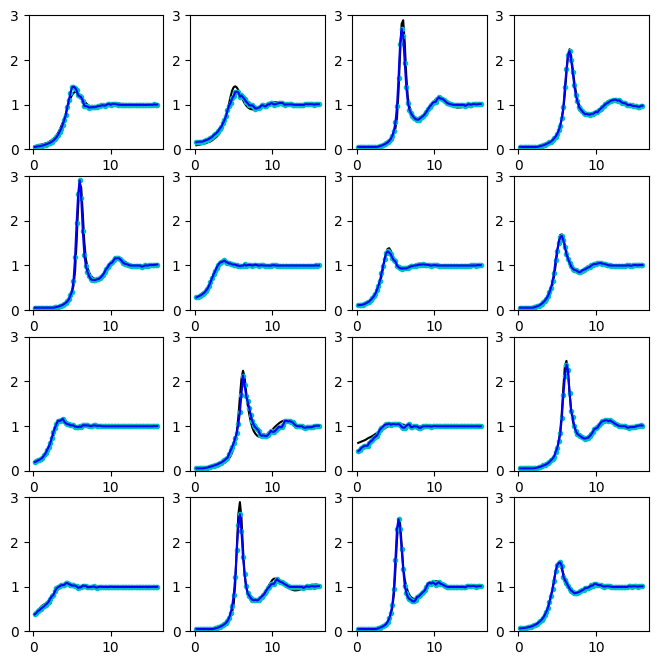

In [37]:
generate_and_save_images(model, 0, test_sample)

err_test_epoch = np.zeros(epochs)
err_test2_epoch = np.zeros(epochs)
err_train_epoch = np.zeros(epochs)
ELBO_train_epoch = np.zeros(epochs)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()
    
    # loss
    err_test = compute_loss(model, test_sample)
    err_train = compute_loss(model, train_x)
    err_test2 = compute_loss(model, test2_sample)
    err_test_epoch[epoch-1] = err_test
    err_test2_epoch[epoch-1] = err_test2
    err_train_epoch[epoch-1] = err_train
        
    display.clear_output(wait=False)
    print('Epoch: {}, err:{:.6}, time elapse for current epoch: {}'.format(epoch, err_train, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)
    
    

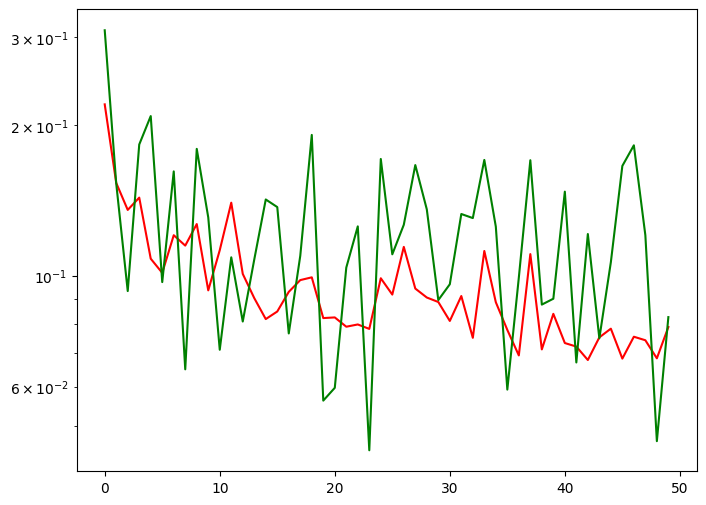

In [38]:
errname = './figures_SQ_cVAE_MSE_ns/err_SQ_cVAE_direct' + name_latent + '_{:04d}.png'
fig2 = plt.figure(figsize=(8, 6))
plt.plot(err_test2_epoch,'-r')
plt.plot(err_train_epoch,'-g')
plt.yscale('log')
#plt.ylim(4e-3, 1e-1)
plt.savefig(errname.format(epoch))
plt.show()

### Display an animated GIF of all the saved images

In [39]:
anim_file = './figures_SQ_cVAE_MSE_ns/SQ_cVAE_direct' + name_latent + '.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures_SQ_cVAE_MSE_ns/image_SQ_cVAE_direct*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


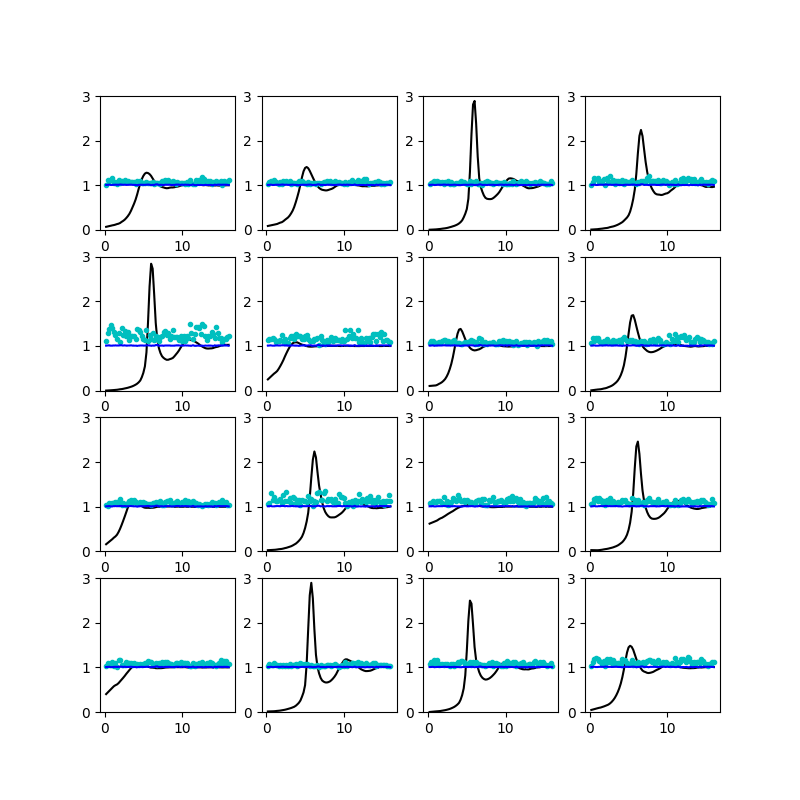

In [40]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Save model

In [41]:
#export_path = './saved_model/SQ_cVAE_MSE_ns/'
#if not os.path.isdir(export_path):
    #os.mkdir(export_path)

In [42]:
#model_name = 'model_conv_stride2'
#export_name = export_path + model_name
#model.save_weights(export_name, overwrite=True, save_format=None, options=None)

## Visualize latent space

In [43]:
def plot_latent_images(model, n, axis_0, axis_1):
    axis_2 = np.setdiff1d(np.arange(3),np.array([axis_0, axis_1]))
    
    zs = sq_test_target
    
    if 1:
        grid_0 = (np.arange(n)*(4/(n-1))-2)*np.std(zs[:,axis_0])+np.mean(zs[:,axis_0])
        grid_1 = (np.arange(n)*(4/(n-1))-2)*np.std(zs[:,axis_1])+np.mean(zs[:,axis_1])
        grid_2 = (np.arange(n)*(4/(n-1))-2)*np.std(zs[:,axis_2])+np.mean(zs[:,axis_2])  

    fig = plt.figure(figsize=(n, n))
    for i, xi in enumerate(grid_0):
        for j, yi in enumerate(grid_1):
            zs_normal = np.array([[xi, yi, grid_2[int((n-1)/2)]]])
            z_normal = zs_normal
            x_decoded = model.sample(z_normal)
            sq_ij = f_out(x_decoded)
            index_fig = n*(n-j-1)+i+1
            
            plt.subplot(n, n, index_fig)
            
            index_exist_x = (zs[:,axis_0]>=xi-np.std(zs[:,axis_0])/(n-1)*4)&(zs[:,axis_0]<xi+np.std(zs[:,axis_0])/(n-1)*4)
            index_exist_y = (zs[:,axis_1]>=yi-np.std(zs[:,axis_1])/(n-1)*4)&(zs[:,axis_1]<yi+np.std(zs[:,axis_1])/(n-1)*4)
            
            if any(index_exist_x&index_exist_y):            
                plt.plot(q_rs,sq_ij[0,:],'r')
            else:
                plt.plot(q_rs,sq_ij[0,:],'k')
            plt.ylim(0, 3)
            plt.gca().axes.get_xaxis().set_ticklabels([])
            plt.gca().axes.get_yaxis().set_ticks([])

    plt.show()

In [ ]:
plot_latent_images(model, n=13, axis_0=1, axis_1=2)